In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 65,537,552
Trainable params: 65,537,552
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 256)         327936    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 256)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0342 - acc: 0.3335
Epoch 00001: val_loss improved from inf to 1.42976, saving model to model/checkpoint/1D_CNN_custom_2_DO_6_conv_checkpoint/001-1.4298.hdf5
36805/36805 [==============================] - 287s 8ms/sample - loss: 2.0341 - acc: 0.3336 - val_loss: 1.4298 - val_acc: 0.5448
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3817 - acc: 0.5525
Epoch 00002: val_loss improved from 1.42976 to 1.08362, saving model to model/checkpoint/1D_CNN_custom_2_DO_6_conv_checkpoint/002-1.0836.hdf5
36805/36805 [==============================] - 284s 8ms/sample - loss: 1.3817 - acc: 0.5525 - val_loss: 1.0836 - val_acc: 0.6662
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1125 - acc: 0.6515
Epoch 00003: val_loss improved from 1.08362 to 0.87089, saving model to model

36800/36805 [============================>.] - ETA: 0s - loss: 0.1646 - acc: 0.9465
Epoch 00024: val_loss improved from 0.32146 to 0.32006, saving model to model/checkpoint/1D_CNN_custom_2_DO_6_conv_checkpoint/024-0.3201.hdf5
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.1646 - acc: 0.9465 - val_loss: 0.3201 - val_acc: 0.9154
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9497
Epoch 00025: val_loss did not improve from 0.32006
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.1571 - acc: 0.9497 - val_loss: 0.3383 - val_acc: 0.9178
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9498
Epoch 00026: val_loss did not improve from 0.32006
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.1525 - acc: 0.9498 - val_loss: 0.3210 - val_acc: 0.9152
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9816
Epoch 00053: val_loss did not improve from 0.32006
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.0576 - acc: 0.9816 - val_loss: 0.4427 - val_acc: 0.9210
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9826
Epoch 00054: val_loss did not improve from 0.32006
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0562 - acc: 0.9826 - val_loss: 0.4304 - val_acc: 0.9271
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9809
Epoch 00055: val_loss did not improve from 0.32006
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.0586 - acc: 0.9809 - val_loss: 0.4173 - val_acc: 0.9248
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9827
Epoch 00056: val_loss did not improve from 0.32006
36805/36805 [=====================

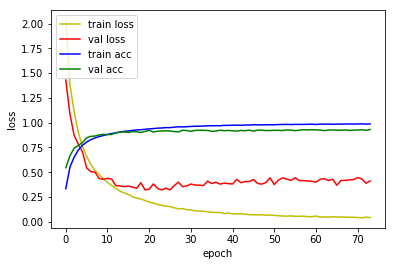

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.3839 - acc: 0.8906
Loss: 0.38391003829048925 Accuracy: 0.8905504

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2048 - acc: 0.2714
Epoch 00001: val_loss improved from inf to 1.39608, saving model to model/checkpoint/1D_CNN_custom_2_DO_7_conv_checkpoint/001-1.3961.hdf5
36805/36805 [==============================] - 288s 8ms/sample - loss: 2.2047 - acc: 0.2714 - val_loss: 1.3961 - val_acc: 0.5628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3817 - acc: 0.5491
Epoch 00002: val_loss improved from 1.39608 to 1.03013, saving model to model/checkpoint/1D_CNN_custom_2_DO_7_conv_checkpoint/002-1.0301.hdf5
36805/36805 [==============================] - 287s 8ms/sample - loss: 1.3816 - acc: 0.5491 - val_loss: 1.0301 - val_acc: 0.6909
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0187 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.1457 - acc: 0.9521
Epoch 00025: val_loss did not improve from 0.16995
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.1457 - acc: 0.9521 - val_loss: 0.1896 - val_acc: 0.9495
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1321 - acc: 0.9559
Epoch 00026: val_loss did not improve from 0.16995
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.1321 - acc: 0.9559 - val_loss: 0.1931 - val_acc: 0.9502
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9580
Epoch 00027: val_loss did not improve from 0.16995
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.1275 - acc: 0.9580 - val_loss: 0.1827 - val_acc: 0.9548
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9579
Epoch 00028: val_loss improved from 0.16995 to 0.16476, saving model to model/checkpo

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9825
Epoch 00054: val_loss did not improve from 0.15886
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0509 - acc: 0.9825 - val_loss: 0.2131 - val_acc: 0.9581
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9808
Epoch 00055: val_loss did not improve from 0.15886
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0565 - acc: 0.9808 - val_loss: 0.1949 - val_acc: 0.9578
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9834
Epoch 00056: val_loss did not improve from 0.15886
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0489 - acc: 0.9834 - val_loss: 0.2090 - val_acc: 0.9590
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.9817
Epoch 00057: val_loss did not improve from 0.15886
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9896
Epoch 00084: val_loss did not improve from 0.15886
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.0331 - acc: 0.9896 - val_loss: 0.2351 - val_acc: 0.9557
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9904
Epoch 00085: val_loss did not improve from 0.15886
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0302 - acc: 0.9904 - val_loss: 0.2613 - val_acc: 0.9562
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9899
Epoch 00086: val_loss did not improve from 0.15886
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0293 - acc: 0.9899 - val_loss: 0.2486 - val_acc: 0.9485

1D_CNN_custom_2_DO_7_conv Model


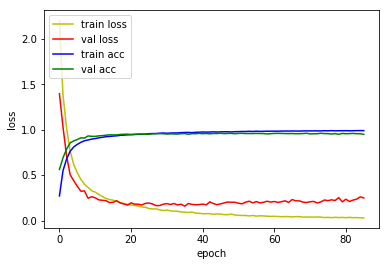

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2010 - acc: 0.9437
Loss: 0.20095838392511212 Accuracy: 0.94371754

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0342 - acc: 0.3336
Epoch 00001: val_loss improved from inf to 1.20668, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/001-1.2067.hdf5
36805/36805 [==============================] - 290s 8ms/sample - loss: 2.0341 - acc: 0.3336 - val_loss: 1.2067 - val_acc: 0.6203
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1837 - acc: 0.6151
Epoch 00002: val_loss improved from 1.20668 to 0.71368, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/002-0.7137.hdf5
36805/36805 [==============================] - 285s 8ms/sample - loss: 1.1836 - acc: 0.6152 - val_loss: 0.7137 - val_acc: 0.7808
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8586 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9599
Epoch 00024: val_loss improved from 0.12048 to 0.11109, saving model to model/checkpoint/1D_CNN_custom_2_DO_8_conv_checkpoint/024-0.1111.hdf5
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.1217 - acc: 0.9599 - val_loss: 0.1111 - val_acc: 0.9658
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9610
Epoch 00025: val_loss did not improve from 0.11109
36805/36805 [==============================] - 287s 8ms/sample - loss: 0.1179 - acc: 0.9610 - val_loss: 0.1143 - val_acc: 0.9658
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9627
Epoch 00026: val_loss did not improve from 0.11109
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.1131 - acc: 0.9627 - val_loss: 0.1309 - val_acc: 0.9646
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1019 - acc: 0

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9834
Epoch 00052: val_loss did not improve from 0.10559
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0489 - acc: 0.9834 - val_loss: 0.1362 - val_acc: 0.9695
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9842
Epoch 00053: val_loss did not improve from 0.10559
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.0455 - acc: 0.9842 - val_loss: 0.1323 - val_acc: 0.9683
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9844
Epoch 00054: val_loss did not improve from 0.10559
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0465 - acc: 0.9844 - val_loss: 0.1246 - val_acc: 0.9655
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9853
Epoch 00055: val_loss did not improve from 0.10559
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9920
Epoch 00082: val_loss did not improve from 0.10559
36805/36805 [==============================] - 284s 8ms/sample - loss: 0.0236 - acc: 0.9920 - val_loss: 0.1502 - val_acc: 0.9695
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9910
Epoch 00083: val_loss did not improve from 0.10559
36805/36805 [==============================] - 285s 8ms/sample - loss: 0.0273 - acc: 0.9910 - val_loss: 0.1463 - val_acc: 0.9720
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9924
Epoch 00084: val_loss did not improve from 0.10559
36805/36805 [==============================] - 284s 8ms/sample - loss: 0.0238 - acc: 0.9924 - val_loss: 0.1272 - val_acc: 0.9718
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9930
Epoch 00085: val_loss did not improve from 0.10559
36805/36805 [========

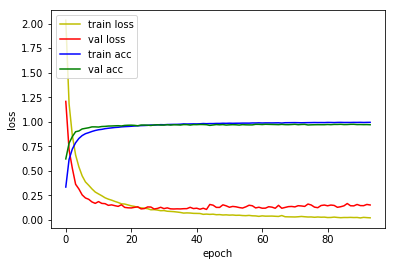

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1738 - acc: 0.9574
Loss: 0.1738346540741429 Accuracy: 0.9574247

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.3325
Epoch 00001: val_loss improved from inf to 1.12985, saving model to model/checkpoint/1D_CNN_custom_2_DO_9_conv_checkpoint/001-1.1299.hdf5
36805/36805 [==============================] - 291s 8ms/sample - loss: 2.0626 - acc: 0.3325 - val_loss: 1.1299 - val_acc: 0.6695
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2171 - acc: 0.6158
Epoch 00002: val_loss improved from 1.12985 to 0.77843, saving model to model/checkpoint/1D_CNN_custom_2_DO_9_conv_checkpoint/002-0.7784.hdf5
36805/36805 [==============================] - 287s 8ms/sample - loss: 1.2173 - acc: 0.6158 - val_loss: 0.7784 - val_acc: 0.7680
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9432 - ac

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9609
Epoch 00025: val_loss did not improve from 0.10899
36805/36805 [==============================] - 293s 8ms/sample - loss: 0.1215 - acc: 0.9609 - val_loss: 0.1353 - val_acc: 0.9637
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9605
Epoch 00026: val_loss did not improve from 0.10899
36805/36805 [==============================] - 294s 8ms/sample - loss: 0.1208 - acc: 0.9605 - val_loss: 0.1171 - val_acc: 0.9686
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1143 - acc: 0.9632
Epoch 00027: val_loss did not improve from 0.10899
36805/36805 [==============================] - 293s 8ms/sample - loss: 0.1143 - acc: 0.9632 - val_loss: 0.1255 - val_acc: 0.9623
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9661
Epoch 00028: val_loss did not improve from 0.10899
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9860
Epoch 00054: val_loss did not improve from 0.10826
36805/36805 [==============================] - 289s 8ms/sample - loss: 0.0424 - acc: 0.9860 - val_loss: 0.1483 - val_acc: 0.9665
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9834
Epoch 00055: val_loss did not improve from 0.10826
36805/36805 [==============================] - 289s 8ms/sample - loss: 0.0512 - acc: 0.9834 - val_loss: 0.1220 - val_acc: 0.9709
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9859
Epoch 00056: val_loss did not improve from 0.10826
36805/36805 [==============================] - 288s 8ms/sample - loss: 0.0428 - acc: 0.9859 - val_loss: 0.1348 - val_acc: 0.9697
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9850
Epoch 00057: val_loss did not improve from 0.10826
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9914
Epoch 00084: val_loss did not improve from 0.10826
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0270 - acc: 0.9914 - val_loss: 0.1460 - val_acc: 0.9709

1D_CNN_custom_2_DO_9_conv Model


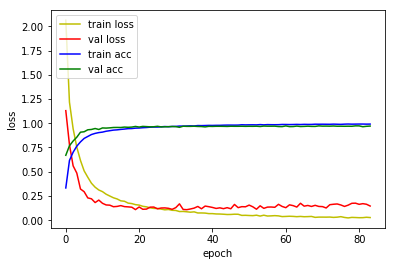

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1531 - acc: 0.9574
Loss: 0.15306521486297545 Accuracy: 0.9574247



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 256)         327936    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 25

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1531 - acc: 0.9574
Loss: 0.15306521486297545 Accuracy: 0.9574247


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 256)         327936    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 25

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2158 - acc: 0.9612
Loss: 0.2158301523139532 Accuracy: 0.96116304
